In [1]:
import numpy as np
import scipy
import math
from scipy.linalg import *
import scipy.integrate as integrate
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
def M_axis(theta,axis):
    theta = theta*np.pi /180 # converts from degs to radians
    M = np.zeros((3,3))
    
    if axis == 1:
        M[0,:] = np.array([1, 0, 0])
        M[1,:] = np.array([0, np.cos(theta), np.sin(theta)])
        M[2,:] = np.array([0, -np.sin(theta), np.cos(theta)])
    
    if axis == 2:
        M[0,:] = np.array([np.cos(theta), 0, -np.sin(theta)])
        M[1,:] = np.array([0, 1, 0])
        M[2,:] = np.array([np.sin(theta), 0, np.cos(theta)])

    if axis == 3:
        M[0,:] = np.array([np.cos(theta), np.sin(theta), 0])
        M[1,:] = np.array([-np.sin(theta), np.cos(theta), 0])
        M[2,:] = np.array([0, 0, 1])

    return M

def DCMatrix(Theta,euler):
    C = M_axis(Theta[2],euler[2])@ M_axis(Theta[1],euler[1]) @ M_axis(Theta[0],euler[0])
    return C

def Matrix_tilde(w):
    w1, w2, w3 = w
    W = np.zeros((3,3))
    W[0,1] = - w3
    W[0,2] = w2
    W[1,0] = w3
    W[1,2] = -w1
    W[2,0] = -w2
    W[2,1] = w1
    
    return W

def MRP_to_DCM(sigma):
    C = np.eye(3) +(8*Matrix_tilde(sigma)@Matrix_tilde(sigma) - 4*(1 - sigma.T@sigma)*Matrix_tilde(sigma))/((1+ sigma.T@sigma)**2)
    return C

def DCM_to_MRP(C, short = True):
    s = np.sqrt(np.trace(C) + 1)
    sigma = np.array([C[1,2]-C[2,1], C[2,0]-C[0,2], C[0,1]-C[1,0]])/(s*(s + 2))
    
    if short :
        return sigma
    else :
        return -sigma/(sigma.T@sigma)
    

def Add_MRPs(sigma1, sigma2):
    s1 = sigma1.T@sigma1 # |sigma1|^2
    s2 = sigma2.T@sigma2 # |sigma2|^2
    sigma = ((1 - s1) * sigma2 + (1 - s2) * sigma1 - 2*np.cross(sigma2, sigma1))/(1 + s1*s2 - 2*sigma1.T@sigma2)
    
    return sigma

def Subtract_MRPs(sigma1, sigma):
    return Add_MRPs(-sigma1, sigma)

In [3]:
def sigma_b_r(s_BN, s_RN, tracking):
    BN = MRP_to_DCM(s_BN)
    if tracking:
        RN = MRP_to_DCM(s_RN)
        BR = BN@(RN.T)
        s_BR = DCM_to_MRP(BR)
    else :
        RN = np.eye(3)
        BR = BN
        s_BR = s_BN
    
    return BR,s_BR

def s_RN(t,f, tracking):
    if tracking:
        return np.array([0.2*np.sin(f*t), 0.3*np.cos(f*t), -0.3*np.sin(f*t)])
    else:
        return np.zeros(3)

def s_RN_dot(t,f, tracking):  
    if tracking:
        return f*np.array([0.2*np.cos(f*t), -0.3*np.sin(f*t), -0.3*np.cos(f*t)])
    else:
        return np.zeros(3)

def Rw_RN(t, f, tracking):
    s_rn = s_RN(t, f, tracking)
    s_rndot = s_RN_dot(t, f,  tracking)
    B_s_RNT = (1-norm(s_rn,2)**2)*np.eye(3) - 2*Matrix_tilde(s_rn) + 2*np.outer(s_rn,s_rn)  # B(s_RN)^T
    R_w_RN = 4/((1 + norm(s_rn,2)**2)**2)*B_s_RNT@s_rndot   #angular velocity of R relative to N: w_R/N in the R frame
    
    return R_w_RN

def w_RN(t, BR, f,tracking):
    return BR@Rw_RN(t,f, tracking)

def w_RN_dot(t, dt, BR, f,tracking):
    return (w_RN(t+dt, BR, f, tracking) - w_RN(t-dt, BR, f, tracking))/(2*dt)
    
def w_BN_dot(t,w, u, L, DeltaL):
    rhs = inv(I)@((-Matrix_tilde(w) @ I) @ w + u + L + DeltaL)
    return rhs

def MRP_dot(t, sigma0, w):
    B_sigma = 0.25*((1- norm(sigma0,2)**2)*np.eye(3) +2*Matrix_tilde(sigma0) +2*np.outer(sigma0,sigma0))
    rhs = B_sigma @ w
    return rhs

def order4(function, tval, x, step, *param):
    k1 = function(tval, x, *param)
    k2 = function(tval + 0.5*step, x + 0.5*step*k1, *param)
    k3 = function(tval + 0.5*step, x + 0.5*step*k2, *param)
    k4 = function(tval + step, x + step*k3, *param)
    
    x = x +step*(k1 + 2*k2 +2*k3 + k4)/6
    
    return x

In [4]:
def control1(s_br,delw, w_bn, w_rn, w_rndot, L):
    u = -k*s_br - P@delw + I@(w_rndot - np.cross(w_bn, w_rn)) + (Matrix_tilde(w_bn)@I)@w_bn - L
    return u

def control2(s_br, delw):
    u = -k*s_br - P@delw
    return u

def control3(s_br, delw, w_bn, w_rn, w_rndot):
    u = control1(s_br,delw, w_bn, w_rn, w_rndot, 0)
    return u

def controlPID(s_br, s_br_integral, delw, delw0, w_bn, w_rn, w_rndot, L, K_I) :
    u = -k*s_br -(P + P@K_I@I)@delw - k*(P@K_I)@s_br_integral + (P@K_I@I)@delw0 + I@(w_rndot - np.cross(w_bn, w_rn)) + (Matrix_tilde(w_bn)@I)@w_bn - L
    return u

In [5]:
def simulation(tspan, sigma_0, w_0, dt,f, I, L, k, P,tracking, control_law, K_I, DeltaL):
    t0, tf = tspan[0], tspan[1]
    t = np.arange(t0, tf, dt)
    nt = len(t)
    
    #history matrices
    Sigma = np.zeros((len(sigma_0), nt)) # time history of the attitude variable
    W = np.zeros((len(w_0), nt))  # time history of angular velocity w_B/N
    U = np.zeros((len(sigma_0), nt)) #time history of the control law
    
    # initial values:
    s_bn = sigma_0  # initialized at time 0
    w_bn = w_0    # initialized at time 0
    s_rn = s_RN(0,f, tracking)
    BR, s_br = sigma_b_r(s_bn, s_rn, tracking)
    w_rn = w_RN(0, BR, f, tracking)
    w_rndot = w_RN_dot(0, dt, BR, f,tracking)
    del_w = w_bn - w_rn
    # control1
    if control_law == 1 :
        u = control1(s_br,del_w, w_bn, w_rn, w_rndot, L)  
    # control2
    if control_law == 2 :
        u = control2(s_br, del_w)
    #control3
    if control_law == 3 :
        u = control3(s_br, del_w, w_bn, w_rn, w_rndot)
        
    # control PID
    if control_law == 'PID':
        del_w0 = del_w
        u = controlPID(s_br, np.array([0,0,0]), del_w, del_w0, w_bn, w_rn, w_rndot, L, K_I)
    

    
    Sigma[:,0] = s_bn
    W[:,0] = w_0
    U[:,0] = u

    # history matrices for the tracking problem
    Sigma_BR = np.zeros(Sigma.shape)
    W_BR = np.zeros(W.shape)
    Sigma_BR[:,0] = s_br
    W_BR[:,0] = del_w
    
    # history matrix of state z for the case of PID control
    Z = np.zeros(Sigma.shape)

    for i in range(1,nt):
        w_bn = order4(w_BN_dot, t[i]-1, w_bn, dt, u, L, DeltaL)
        s_bn = order4(MRP_dot, t[i]-1, s_bn, dt, w_bn)
        if norm(s_bn, 2) >= 1:
            s_bn = -s_bn/(norm(s_bn,2)**2)
        
        s_rn = s_RN(t[i], f, tracking)
        BR, s_br = sigma_b_r(s_bn, s_rn, tracking)
        w_rn = w_RN(t[i], BR, f, tracking)
        w_rndot = w_RN_dot(t[i], dt, BR, f, tracking)
        del_w = w_bn - w_rn
        
        Sigma[:,i] = s_bn
        W[:, i] = w_bn
        Sigma_BR[:,i] = s_br
        W_BR[:,i] = del_w

        # control1:
        if control_law == 1 :        
            u = control1(s_br,del_w, w_bn, w_rn, w_rndot, L)    
        
        # control2:
        if control_law == 2 :
            u = control2(s_br, del_w)
            
        # control3:
        if control_law == 3 :
            u = control3(s_br, del_w, w_bn, w_rn, w_rndot)

        # control PID
        if control_law == 'PID':
            s_br_integral = integrate.trapz(Sigma_BR[:,0:i], dx = dt, axis =1)
            u = controlPID(s_br, s_br_integral, del_w, del_w0, w_bn, w_rn, w_rndot, L, K_I)
            z = k*s_br_integral +I@(del_w -del_w0)
            Z[:,i] = z

        U[:,i] = u
    return Sigma, W, U, Sigma_BR, W_BR, Z

In [6]:
def Tracking(tspan, sigma_0, w_0, dt, f, I, L, k, P, control_law, K_I = 0, DeltaL = 0) :
    tracking = True
    _, _, U, Sigma_BR, W_BR, Z = simulation(tspan,sigma_0, w_0, dt, f, I, L, k, P, tracking, control_law, K_I, DeltaL)
    sbr1 = Sigma_BR[0,:]
    sbr2 = Sigma_BR[1,:]
    sbr3 = Sigma_BR[2,:]
    wbr1 = W_BR[0,:]
    wbr2 = W_BR[1,:]
    wbr3 = W_BR[2,:]
    u1 = U[0,:]
    u2 = U[1,:]
    u3 = U[2,:]
    t = np.arange(tspan[0],tspan[1], dt)

    plt.figure(figsize = (20,6))
    plt.subplot(121)
    plt.plot(t,sbr1, label = '$\sigma_1$')
    plt.plot(t,sbr2, label =' $\sigma_2$')
    plt.plot(t, sbr3, label = '$\sigma_3$')
    plt.xlabel('time [s]')
    plt.ylabel('Error attitude vector')
    plt.legend()
    plt.title('Attitude vector $\sigma_{B/R}$')
    plt.subplot(122)
    plt.plot(t,wbr1,label='$\omega_1$')
    plt.plot(t,wbr2, label='$\omega_2$')
    plt.plot(t,wbr3, label ='$\omega_3$')
    plt.xlabel('time [s]')
    plt.ylabel('Angular velocities [rad/s]')
    plt.legend()
    plt.title('Angular velocity vector $\omega_{B/R}$')

    plt.figure(figsize = (12,6))
    plt.plot(t, u1, label ='u1')
    plt.plot(t, u2, label ='u2')
    plt.plot(t, u3, label ='u3')
    plt.xlabel('time [s]')
    plt.ylabel('control vector [N-m]')
    plt.legend()
    plt.title('control law')

    plt.show()
    if control_law == 'PID':
        return Sigma_BR, W_BR, Z
    else :
        return Sigma_BR, W_BR

In [7]:
def Regulator(tspan, sigma_0, w_0, dt, I, L, k, P, control_law, K_I = 0, DeltaL = 0) :
    tracking = False
    f = 0
    Sigma, W, U, _, _, Z = simulation(tspan,sigma_0, w_0, dt, f, I, L, k, P, tracking, control_law, K_I, DeltaL)
    s1 = Sigma[0,:]
    s2 = Sigma[1,:]
    s3 = Sigma[2,:]
    w1 = W[0,:]
    w2 = W[1,:]
    w3 = W[2,:]
    u1 = U[0,:]
    u2 = U[1,:]
    u3 = U[2,:]
    t = np.arange(tspan[0],tspan[1], dt)

    plt.figure(figsize = (20,6))
    plt.subplot(121)
    plt.plot(t,s1, label = '$\sigma_1$')
    plt.plot(t,s2, label =' $\sigma_2$')
    plt.plot(t, s3, label = '$\sigma_3$')
    plt.xlabel('time [s]')
    plt.ylabel('Attitude')
    plt.legend()
    plt.title('Attitude vector $\sigma_{B/N}$')
    plt.subplot(122)
    plt.plot(t,w1,label='$\omega_1$')
    plt.plot(t,w2, label='$\omega_2$')
    plt.plot(t,w3, label ='$\omega_3$')
    plt.xlabel('time [s]')
    plt.ylabel('Angular velocities [rad/s]')
    plt.legend()
    plt.title('Angular velocity vector $\omega_{B/N}$')

    plt.figure(figsize = (12,6))
    plt.plot(t, u1, label ='u1')
    plt.plot(t, u2, label ='u2')
    plt.plot(t, u3, label ='u3')
    plt.xlabel('time [s]')
    plt.ylabel('control vector [N-m]')
    plt.legend()
    plt.title('control law')

    plt.show()
    
    if control_law == 'PID':
        return Sigma, W, Z
    else :
        return Sigma, W
    

In [8]:
I = np.diag([100,75,80])
k = 5
P = 10*np.eye(3)
sigma_0 = np.array([0.1, 0.2, -0.1])
w_0 = np.array([30, 10, -20])  # deg/s
w_0 = (np.pi/180)*w_0

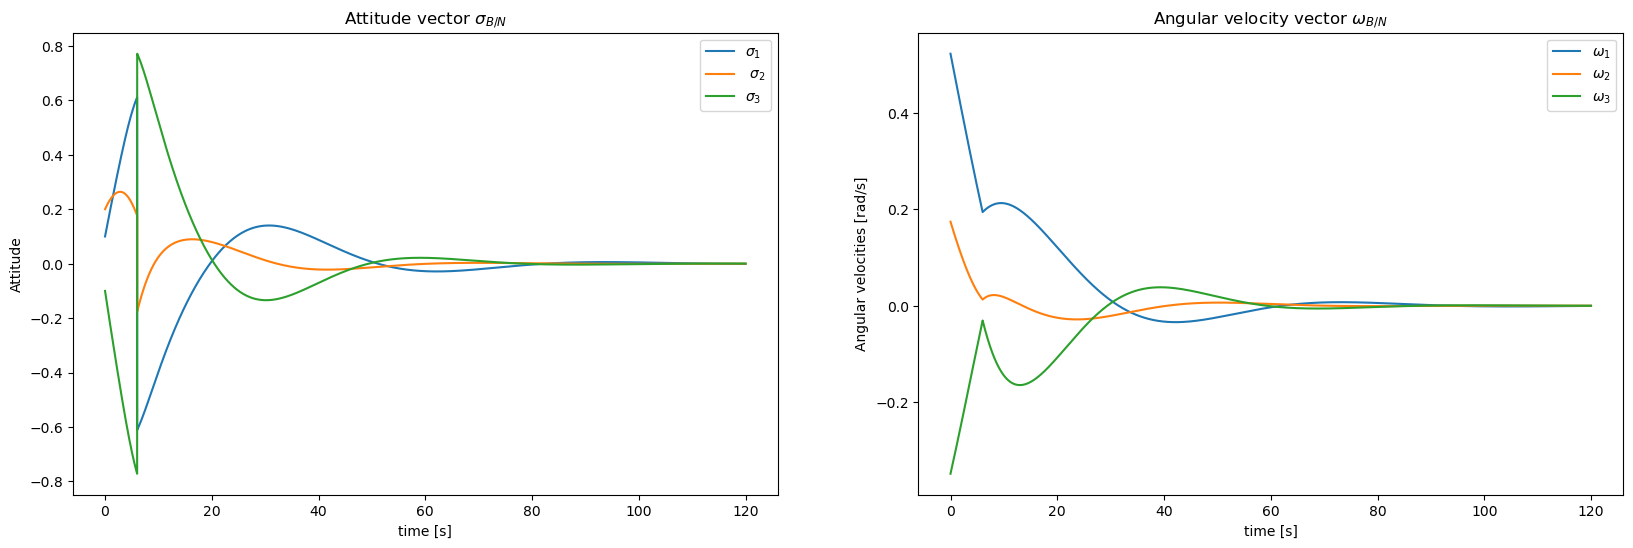

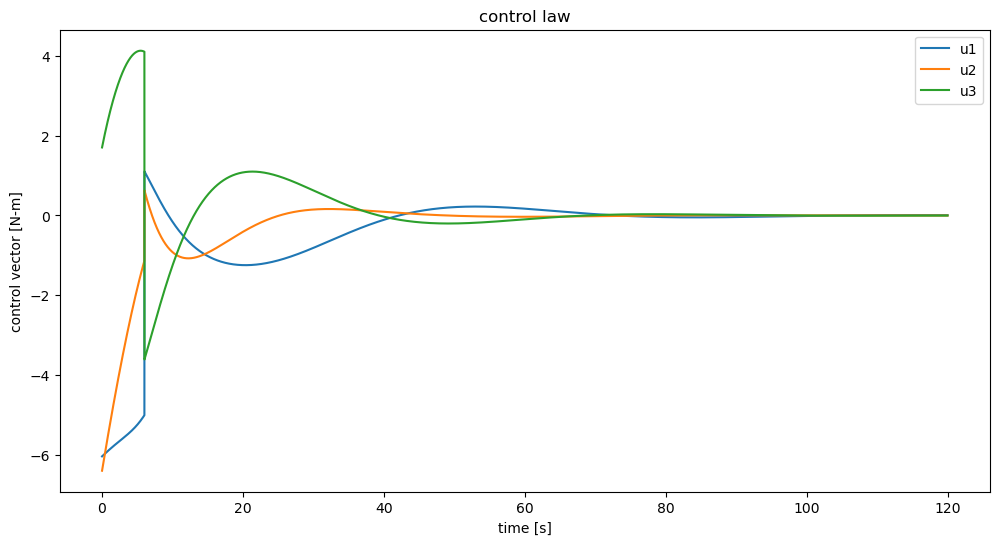

In [11]:
# for the Regulator problem, compute the norm of the attitude at 30 seconds:

S, W = Regulator((0,120), sigma_0, w_0, 0.01, I, 0, k, P, control_law=1)

In [13]:
print(' The orientation $\sigma$ at 120 seconds and its norm are: ', S[:,11999], norm(S[:,11999],2))

 The orientation $\sigma$ at 120 seconds and its norm are:  [-1.01277506e-03  3.59407737e-05  5.39261857e-04] 0.0011479583694549514


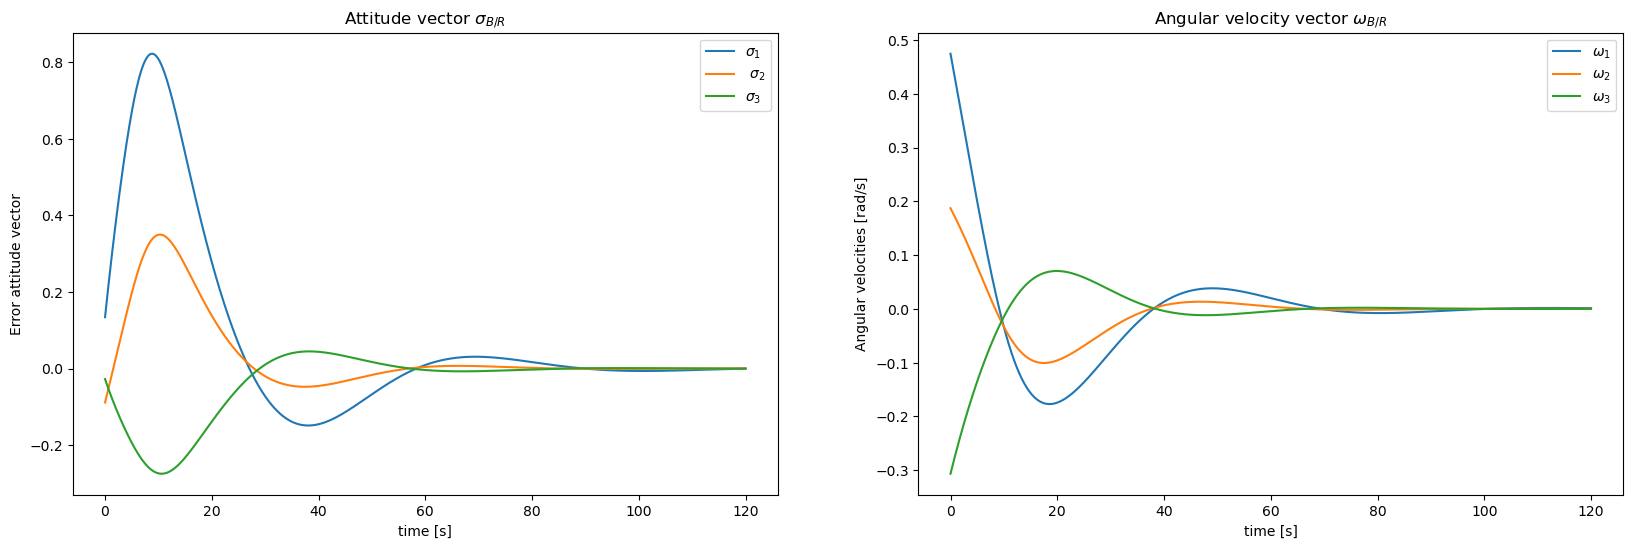

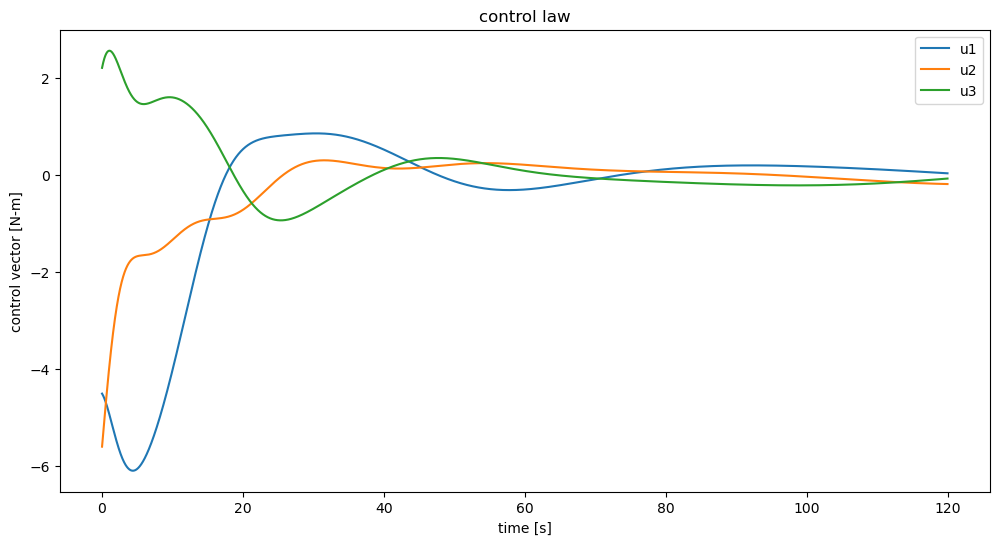

In [14]:
S_BR, W_BR = Tracking((0,120), sigma_0, w_0, 0.01, 0.05, I, 0, k, P, control_law = 1)

In [15]:
print('the error orientation at time 40 sec and its norm are: ', S_BR[:,4000], ' ', norm(S_BR[:,4000],2))

the error orientation at time 40 sec and its norm are:  [-0.14556957 -0.04546988  0.04369857]   0.1586429154870994


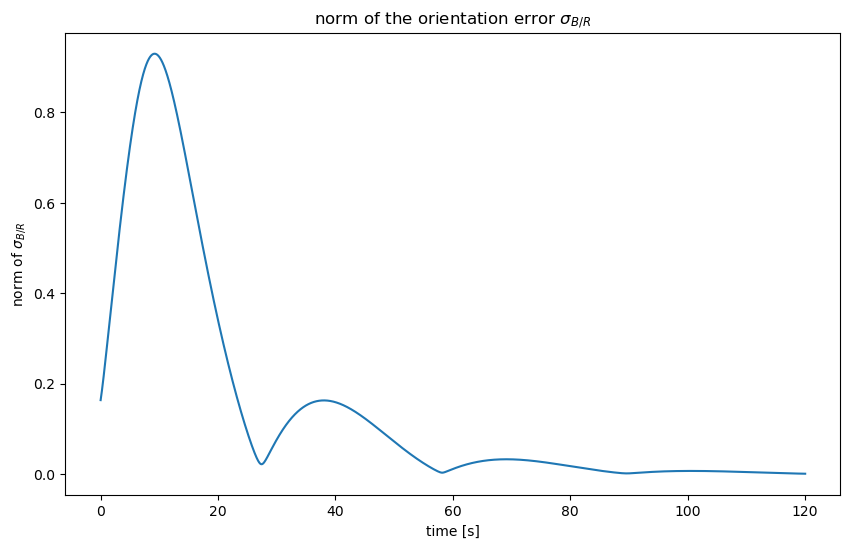

In [16]:
plt.figure(figsize = (10,6))
plt.plot(np.arange(0,120,0.01), norm(S_BR, 2, 0))
plt.xlabel('time [s]')
plt.ylabel('norm of $\sigma_{B/R}$')
plt.title('norm of the orientation error $\sigma_{B/R}$')
plt.show()